# KR-WordRank
- 비지도학습으로 한국어 텍스트에서 키워드를 자동으로 추출해주는 라이브러리
- **주요 가정 : 단어 주변에는 단어가 등장하며, 올바른 단어는 주위의 많은 단어들과 연결되어 있다. 따라서 단어는 주위 단어들에 의하여 단어 점수가 보강(reinforced)된다.**
- [KR-WordRank Reference](https://github.com/lovit/KR-WordRank)
- [Setup]
```
pip install krwordrank
```

### 전체 파일 합치기
- [지속가능경영보고서 DB](https://www.ksa.or.kr/ksi/4982/subview.do)에서 추출한 pdf 파일을 변환하여 진행

In [1]:
import os
os.chdir('../data/')

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm, tqdm_pandas

year = [str(x) for x in range(2018, 2022)]   # 2018 ~ 2021
df = pd.DataFrame(columns = ['year', 'fileName', 'text', 'rhino_preprocessing', 'keywords'])
df

,year,fileName,text,rhino_preprocessing,keywords


In [3]:
for y in tqdm(year):
    fileList = os.listdir('./' + y)
    for file in fileList:
        with open('./' + y + '/' + file, 'r') as f:
            text = f.read().splitlines()
        if text and text[0].strip():
            df_slice = pd.Series([y, file, text[0].strip(), 0, 0], index = df.columns)
            df = df.append(df_slice, ignore_index = True)
# df.to_csv('rhino_all_before_preprocessing.csv', index = False)

100%|██████████| 4/4 [00:01<00:00,  3.79it/s]


In [4]:
df.head()

,year,fileName,text,rhino_preprocessing,keywords
0,2018,한국산업인력공단 지속가능보고서(2017...,지속가능경영 보고서 목차 보고...,0,0
1,2018,LGCNS_Sustainability_Report_2017-2018.pdf.txt,- 보고서 ...,0,0
2,2018,한국국토정보공사 2017 지속가능경영보ᄀ...,지속가능경영보고서 한 국 국 토 정 보 공 사 지 속 가 능 경...,0,0
3,2018,2018 롯데건설 지속가능경영보고서.pdf.txt,롯데건설 지속가능경영보고서 보고서 개요 보고서 특징 롯데건설은 년...,0,0
4,2018,2018_NH투자증권.pdf.txt,투 자 증 권 지 속 가 능 경 영 보 고 서 서울특별시 영등포구 여의...,0,0


In [5]:
len(df)

236

### 정규표현식으로 전처리 + Rhino 형태소 분석

In [7]:
import re
import rhinoMorph
rn = rhinoMorph.startRhino()

def preprocessing_regex_rhino_All(text):
    
    afterText = re.sub('[^가-힣]', ' ', text)                # 한글만
    afterText = re.sub('/\r\n|\r|\n/', ' ', afterText)      # 개행문자 제거
    afterText = re.sub(' +', ' ', afterText)                # 연속된 공백 한개로
    
    # 실질형태소만, 동사의 어말어미 포함, 조사 제외
    # eomi=True : 동사, 형용사 계열 뒤에 모두 '-다'를 붙여주는 것
    # combineN=True : (default)False, 명사가 붙어있을 때, 하나의 형태소로 보는 것(더 나을 때가 있음)
    result = rhinoMorph.onlyMorph_list(rn, afterText, pos = ['NNG', 'NNP', 'NP', 'VV', 'VA', 'XR', 'IC', 'MM', 'MAG', 'MAJ'], eomi = True, combineN = True, xrVv = True)
    
    return [word for word in result if len(word) > 1]       # 1글자는 제외

filepath:  /opt/anaconda3/lib/python3.8/site-packages
classpath:  /opt/anaconda3/lib/python3.8/site-packages/rhinoMorph/lib/rhino.jar
JVM is already started~
RHINO started!


In [8]:
tqdm.pandas()

df['rhino_preprocessing'] = df['text'].progress_apply(preprocessing_regex_rhino_All)   # tqdm 적용
df.head()

/opt/anaconda3/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 236/236 [02:20<00:00,  1.68it/s]


,year,fileName,text,rhino_preprocessing,keywords
0,2018,한국산업인력공단 지속가능보고서(2017...,지속가능경영 보고서 목차 보고...,"[지속가능경영, 보고서, 목차, 보고서개요, 기관소개, 지속가능경영, 소개, 경영추...",0
1,2018,LGCNS_Sustainability_Report_2017-2018.pdf.txt,- 보고서 ...,"[보고서, 개요, 보다, 보고서, 발간하다, 보고서, 지속가능경영, 전략, 소개, ...",0
2,2018,한국국토정보공사 2017 지속가능경영보ᄀ...,지속가능경영보고서 한 국 국 토 정 보 공 사 지 속 가 능 경...,"[지속가능경영보고서, 보다, 보다, 서다, 잇다, 보고서, 개요, 한국국토정보공, ...",0
3,2018,2018 롯데건설 지속가능경영보고서.pdf.txt,롯데건설 지속가능경영보고서 보고서 개요 보고서 특징 롯데건설은 년...,"[롯데건설, 지속가능경영보고서, 보고서, 개요, 보고서, 특징, 롯데건설, 이후, ...",0
4,2018,2018_NH투자증권.pdf.txt,투 자 증 권 지 속 가 능 경 영 보 고 서 서울특별시 영등포구 여의...,"[보다, 서울특별시, 영등포구, 여의다, 투자증권빌딩, 투자증권, 지속가능경영보고서...",0


In [9]:
df.to_csv('rhino_all_before_extracting_keywords.csv', index = False)

In [10]:
len(df.rhino_preprocessing[0])

8791

### 키워드 추출

summarize_with_keywords(text)와 wordrank_extractor.extract(text, beta, max_iter)는 같은 기능을 함

In [11]:
# KRWordRank '기본' 파라미터 값 적용
from krwordrank.word import KRWordRank
from krwordrank.hangle import normalize      # 숫자, 영어 포함 여부
from krwordrank.word import summarize_with_keywords
import numpy as np

def extract_keywords_default(text):
    error_cnt = 0
    try:
        min_count = 5       # 단어의 최소 출현 빈도수 (그래프 생성 시) [5, 3]
        max_length = 10     # 단어의 최대 길이 [10, 30]
        verbose = False     # [True, False]
        wordrank_extractor = KRWordRank(min_count, max_length, verbose)

        beta = 0.85         # PageRank의 decaying factor beta
        max_iter = 10       # [10, 30]

#         text = normalize(text, english = False, number = False).split(' ')        # wordrank_extractor.extract() 함수를 쓰려면 text가 List 형태여야 함
        keywords, rank, graph = wordrank_extractor.extract(text, beta, max_iter)

#         stopwords = {'대한','의견','단어'}
#         keywords = summarize_with_keywords(text, min_count = 3, max_length = 30, beta = 0.85, max_iter = 30, stopwords = stopwords, verbose = True)
#         keywords = summarize_with_keywords(text)    # with default arguments
        result = sorted(keywords.items(), key = lambda x:x[1], reverse = True)

        # return [result[x][0] for x in range(len(result))]   # 단어만
        return result                                         # 단어 + 점수
    
    except:
        error_cnt += 1
        print(error_cnt)
        
        return np.nan

In [12]:
# KRWordRank '수정된' 파라미터 값 적용
from krwordrank.word import KRWordRank
from krwordrank.hangle import normalize      # 숫자, 영어 포함 여부
from krwordrank.word import summarize_with_keywords
import numpy as np

def extract_keywords(text):
    error_cnt = 0
    try:
        min_count = 3       # 단어의 최소 출현 빈도수 (그래프 생성 시) [5, 3]
        max_length = 30     # 단어의 최대 길이 [10, 30]
        verbose = False     # [True, False]
        wordrank_extractor = KRWordRank(min_count, max_length, verbose)

        beta = 0.85         # PageRank의 decaying factor beta
        max_iter = 30       # [10, 30]

#         text = normalize(text, english = False, number = False).split(' ')        # wordrank_extractor.extract() 함수를 쓰려면 text가 List 형태여야 함
        keywords, rank, graph = wordrank_extractor.extract(text, beta, max_iter)

#         stopwords = {'대한','의견','단어'}
#         keywords = summarize_with_keywords(text, min_count = 3, max_length = 30, beta = 0.85, max_iter = 30, stopwords = stopwords, verbose = True)
#         keywords = summarize_with_keywords(text)    # with default arguments
        result = sorted(keywords.items(), key = lambda x:x[1], reverse = True)

        # return [result[x][0] for x in range(len(result))]   # 단어만
        return result                                         # 단어 + 점수
    
    except:
        error_cnt += 1
        print(error_cnt)
        
        return np.nan

In [13]:
tqdm.pandas()

df['keywords'] = df['rhino_preprocessing'].progress_apply(extract_keywords)    # tqdm 적용
df.head()

/opt/anaconda3/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 236/236 [00:55<00:00,  4.24it/s]


,year,fileName,text,rhino_preprocessing,keywords
0,2018,한국산업인력공단 지속가능보고서(2017...,지속가능경영 보고서 목차 보고...,"[지속가능경영, 보고서, 목차, 보고서개요, 기관소개, 지속가능경영, 소개, 경영추...","[(위하, 5.587173942924778), (통하, 4.4460386709529..."
1,2018,LGCNS_Sustainability_Report_2017-2018.pdf.txt,- 보고서 ...,"[보고서, 개요, 보다, 보고서, 발간하다, 보고서, 지속가능경영, 전략, 소개, ...","[(위하, 6.174900383756149), (안전, 5.9991329900513..."
2,2018,한국국토정보공사 2017 지속가능경영보ᄀ...,지속가능경영보고서 한 국 국 토 정 보 공 사 지 속 가 능 경...,"[지속가능경영보고서, 보다, 보다, 서다, 잇다, 보고서, 개요, 한국국토정보공, ...","[(공간, 9.202392025291969), (국토, 6.7604949903023..."
3,2018,2018 롯데건설 지속가능경영보고서.pdf.txt,롯데건설 지속가능경영보고서 보고서 개요 보고서 특징 롯데건설은 년...,"[롯데건설, 지속가능경영보고서, 보고서, 개요, 보고서, 특징, 롯데건설, 이후, ...","[(안전, 7.9274563583972615), (롯데, 7.323033700290..."
4,2018,2018_NH투자증권.pdf.txt,투 자 증 권 지 속 가 능 경 영 보 고 서 서울특별시 영등포구 여의...,"[보다, 서울특별시, 영등포구, 여의다, 투자증권빌딩, 투자증권, 지속가능경영보고서...","[(금융, 11.744767569591952), (투자, 9.712934707223..."


In [86]:
df.keywords[0][:20]

[('위하', 5.587173942924778),
 ('통하', 4.446038670952912),
 ('운영', 4.024481761380939),
 ('추진', 3.5209719339443972),
 ('근로', 3.3623637228895906),
 ('지원', 3.2758540426248075),
 ('국가', 3.2515795561776444),
 ('사회', 3.131288650694633),
 ('지속', 3.0613694108177),
 ('사업', 2.9924654983968724),
 ('취업', 2.7659890082138947),
 ('한국', 2.5010695894921153),
 ('실시', 2.4212286890852526),
 ('직업', 2.397905835222033),
 ('대하', 2.2980193354764555),
 ('주요', 2.290249462030271),
 ('고객', 2.257189317248697),
 ('윤리', 2.214087494571397),
 ('교육', 2.0937609051323203),
 ('전문', 2.0679938395187616)]

In [17]:
tqdm.pandas()

df['keywords_default'] = df['rhino_preprocessing'].progress_apply(extract_keywords_default)    # tqdm 적용
df.head()

/opt/anaconda3/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 236/236 [00:34<00:00,  6.92it/s]


,year,fileName,text,rhino_preprocessing,keywords,keywords_default
0,2018,한국산업인력공단 지속가능보고서(2017...,지속가능경영 보고서 목차 보고...,"[지속가능경영, 보고서, 목차, 보고서개요, 기관소개, 지속가능경영, 소개, 경영추...","[(위하, 5.587173942924778), (통하, 4.4460386709529...","[(위하, 4.151493617815554), (운영, 3.4068759451316..."
1,2018,LGCNS_Sustainability_Report_2017-2018.pdf.txt,- 보고서 ...,"[보고서, 개요, 보다, 보고서, 발간하다, 보고서, 지속가능경영, 전략, 소개, ...","[(위하, 6.174900383756149), (안전, 5.9991329900513...","[(위하, 4.984467328496432), (서비, 4.3058839677113..."
2,2018,한국국토정보공사 2017 지속가능경영보ᄀ...,지속가능경영보고서 한 국 국 토 정 보 공 사 지 속 가 능 경...,"[지속가능경영보고서, 보다, 보다, 서다, 잇다, 보고서, 개요, 한국국토정보공, ...","[(공간, 9.202392025291969), (국토, 6.7604949903023...","[(공간, 7.323434051758898), (지속, 4.9432499351776..."
3,2018,2018 롯데건설 지속가능경영보고서.pdf.txt,롯데건설 지속가능경영보고서 보고서 개요 보고서 특징 롯데건설은 년...,"[롯데건설, 지속가능경영보고서, 보고서, 개요, 보고서, 특징, 롯데건설, 이후, ...","[(안전, 7.9274563583972615), (롯데, 7.323033700290...","[(안전, 5.990364783261364), (롯데, 4.6713327013056..."
4,2018,2018_NH투자증권.pdf.txt,투 자 증 권 지 속 가 능 경 영 보 고 서 서울특별시 영등포구 여의...,"[보다, 서울특별시, 영등포구, 여의다, 투자증권빌딩, 투자증권, 지속가능경영보고서...","[(금융, 11.744767569591952), (투자, 9.712934707223...","[(금융, 9.270241161174235), (투자, 6.1964324646261..."


In [19]:
df.to_csv('rhino_all_after_keywords.csv', index = False)

### 중복 키워드 확인

In [20]:
keyword_counter = {}

for keywords in df.keywords:
    words, ranks = zip(*keywords)
    for word in words:
        keyword_counter[word] = keyword_counter.get(word, 0) + 1

common_keywords = {word for word, count in keyword_counter.items() if count == len(df)}    # 모든 보고서에 등장하는 키워드
len(common_keywords)

1

In [21]:
common_keywords

{'위하'}

In [22]:
len(keyword_counter)

9027

In [23]:
keyword_counter = sorted(keyword_counter.items(), key = lambda x:x[1], reverse = True)
keyword_counter = list(keyword_counter)
keyword_counter[:10]

[('위하', 236),
 ('통하', 235),
 ('운영', 235),
 ('지원', 235),
 ('사회', 235),
 ('지속', 235),
 ('사업', 235),
 ('대하', 235),
 ('노력', 235),
 ('제공', 235)]

In [ ]:
df_keyword_counter = pd.DataFrame(keyword_counter, columns = ['words', 'count'])
df_keyword_counter.to_csv('keyword_counter.csv', index = False)
df_keyword_counter.head()

### 키워드 EDA

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


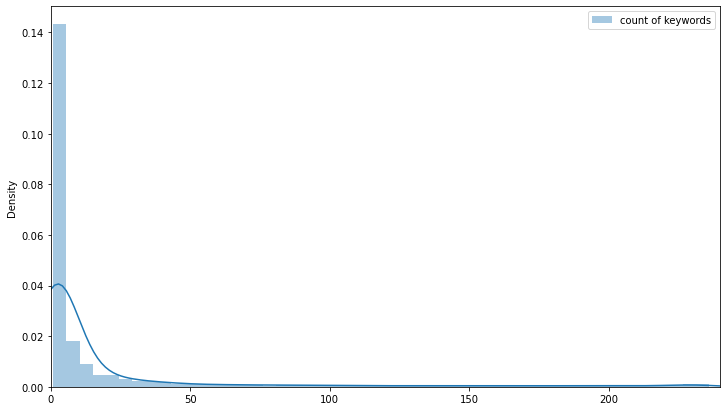

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (12, 7))
sns.distplot(list(zip(*keyword_counter))[1], label = "count of keywords")
plt.xlim(0, 240)
plt.legend()

In [26]:
df_keyword_cnt = pd.DataFrame(list(zip(*keyword_counter))[1], columns = ['count'])
df_keyword_cnt['count'].describe()

count    9027.000000
mean       19.334441
std        45.338935
min         1.000000
25%         1.000000
50%         2.000000
75%        10.000000
max       236.000000
Name: count, dtype: float64

### 정리
1. 전체 text에서 형태소 분석 없이 키워드 추출
2. Mecab으로 키워드 추출 > 조사, 형식형태소 등 쓸모없는 비율이 많음
3. Rhino로 키워드 추출(품사 지정해서 의미없는 키워드 사전 제거)
    * Rhino의 장점
    1. 품사 설정이 가능하기 때문에 조사, 형식형태소 등이 빠져서 stopwords 설정하는데 훨씬 수월함
    2. 1-2개씩잘려 있는 단어도 제거됨
    3. xrVv, combineN 설정을 해줬으니 1글자는 제외해도 됨
4. 키워드 직접 라벨링하여 stopwords와 E, S, G로 나누면 > 상위 키워드, ESG에 해당하는 비율 산출

### 추가 의견
* 20~30번 이상 나왔던 단어들을 제외한 각 보고서의 특색 있는 단어들을 상위키워드로 보여주는 게 좋겠다 - 1. wordrank 2. TF-IDF
* 키워드 라벨링 - 인당 1000개 정도
* 보고서 개수가 236갠데 전체 기업 수랑 표본 데이터에 있는 기업이 포함되는지 확인
* 방향성 변경
    1. 키워드를 임베딩 벡터를 만들고 주요 키워드 유사 집합군을 만들어서 그것의 키워드를 보자
    2. 문장을 라벨링해서 KoBERT 적용 방안